In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#from pandas.core.common import SettingWithCopyWarning
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2, stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
#import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import joblib
import os
%matplotlib inline


Loading datasets

In [ ]:
df_application = pd.read_csv('https://raw.githubusercontent.com/semasuka/Credit-card-approval-prediction-classification/main/datasets/application_record.csv')
df_credit = pd.read_csv('https://raw.githubusercontent.com/semasuka/Credit-card-approval-prediction-classification/main/datasets/credit_record.csv')


In [ ]:
df_application.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [ ]:
df_application.info()
df_application.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [ ]:
df_credit.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [ ]:
df_credit.info()
df_credit.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [ ]:
df_application= pd.merge(df_application, df_credit, on='ID' , how='inner')

Making the target

In [ ]:
def classify_client(status):
    if status in ['2', '3', '4', '5']:
        return 1
    else:
        return 0

df_application['Is high risk'] = df_application['STATUS'].apply(classify_client)

In [ ]:
df_application=df_application.drop('STATUS',axis=1)

In [ ]:
df_application.info()
df_application.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,0
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,0
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,0
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,0
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,0
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-5,0
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-6,0
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-7,0
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-8,0
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-9,0


In [ ]:
begin_month=pd.DataFrame(df_credit.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
df_application=pd.merge(df_application,begin_month,how='left',on='ID')

<ipython-input-11-afa79ba1aaa8>:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month=pd.DataFrame(df_credit.groupby(['ID'])['MONTHS_BALANCE'].agg(min))


In [ ]:
df_application=df_application.drop('MONTHS_BALANCE',axis=1)

In [ ]:
columns_order = [col for col in df_application.columns if col != 'Is high risk'] + ['Is high risk']
df_application = df_application[columns_order]

Renaming application dataset

In [ ]:
df_application = df_application.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [ ]:
df_application.head(10)

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,0


In [ ]:
df_application.info()
df_application.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   Gender               777715 non-null  object 
 2   Has a car            777715 non-null  object 
 3   Has a property       777715 non-null  object 
 4   Children count       777715 non-null  int64  
 5   Income               777715 non-null  float64
 6   Employment status    777715 non-null  object 
 7   Education level      777715 non-null  object 
 8   Marital status       777715 non-null  object 
 9   Dwelling             777715 non-null  object 
 10  Age                  777715 non-null  int64  
 11  Employment length    777715 non-null  int64  
 12  Has a mobile phone   777715 non-null  int64  
 13  Has a work phone     777715 non-null  int64  
 14  Has a phone          777715 non-null  int64  
 15  Has an email     

,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age,Is high risk
count,7.777150e+05,777715.000000,7.777150e+05,777715.000000,777715.000000,777715.0,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000
mean,5.078743e+06,0.428082,1.885348e+05,-16124.937046,57775.825016,1.0,0.231818,0.300965,0.091675,2.208837,-34.751485,0.003636
std,4.180442e+04,0.745755,1.016225e+05,4104.304018,136471.735391,0.0,0.421993,0.458678,0.288567,0.907380,15.031056,0.060192
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,5.044568e+06,0.000000,1.215000e+05,-19453.000000,-3292.000000,1.0,0.000000,0.000000,0.000000,2.000000,-47.000000,0.000000
50%,5.069530e+06,0.000000,1.620000e+05,-15760.000000,-1682.000000,1.0,0.000000,0.000000,0.000000,2.000000,-36.000000,0.000000
75%,5.115551e+06,1.000000,2.250000e+05,-12716.000000,-431.000000,1.0,0.000000,1.000000,0.000000,3.000000,-23.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,1.000000


In [ ]:
df_credit.info()
df_credit.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


splitting dataset as train and test

In [ ]:
'''
from sklearn.model_selection import train_test_split
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)
df_application, df_application_test = data_split(df_application, 0.2)
'''

'\nfrom sklearn.model_selection import train_test_split\ndef data_split(df, test_size):\n    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)\n    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)\ndf_application, df_application_test = data_split(df_application, 0.2)\n'

In [ ]:

df_application.to_csv('df_application',index=False)


In [ ]:
'''
df_application_test.to_csv('df_application_test',index=False)
'''

"\ndf_application_test.to_csv('df_application_test',index=False)\n"

In [ ]:
# creating a copy of the dataset so that the original stays untouched
df_application_copy = df_application.copy()


In [ ]:
df_application_copy.shape

(777715, 20)

Missing Values

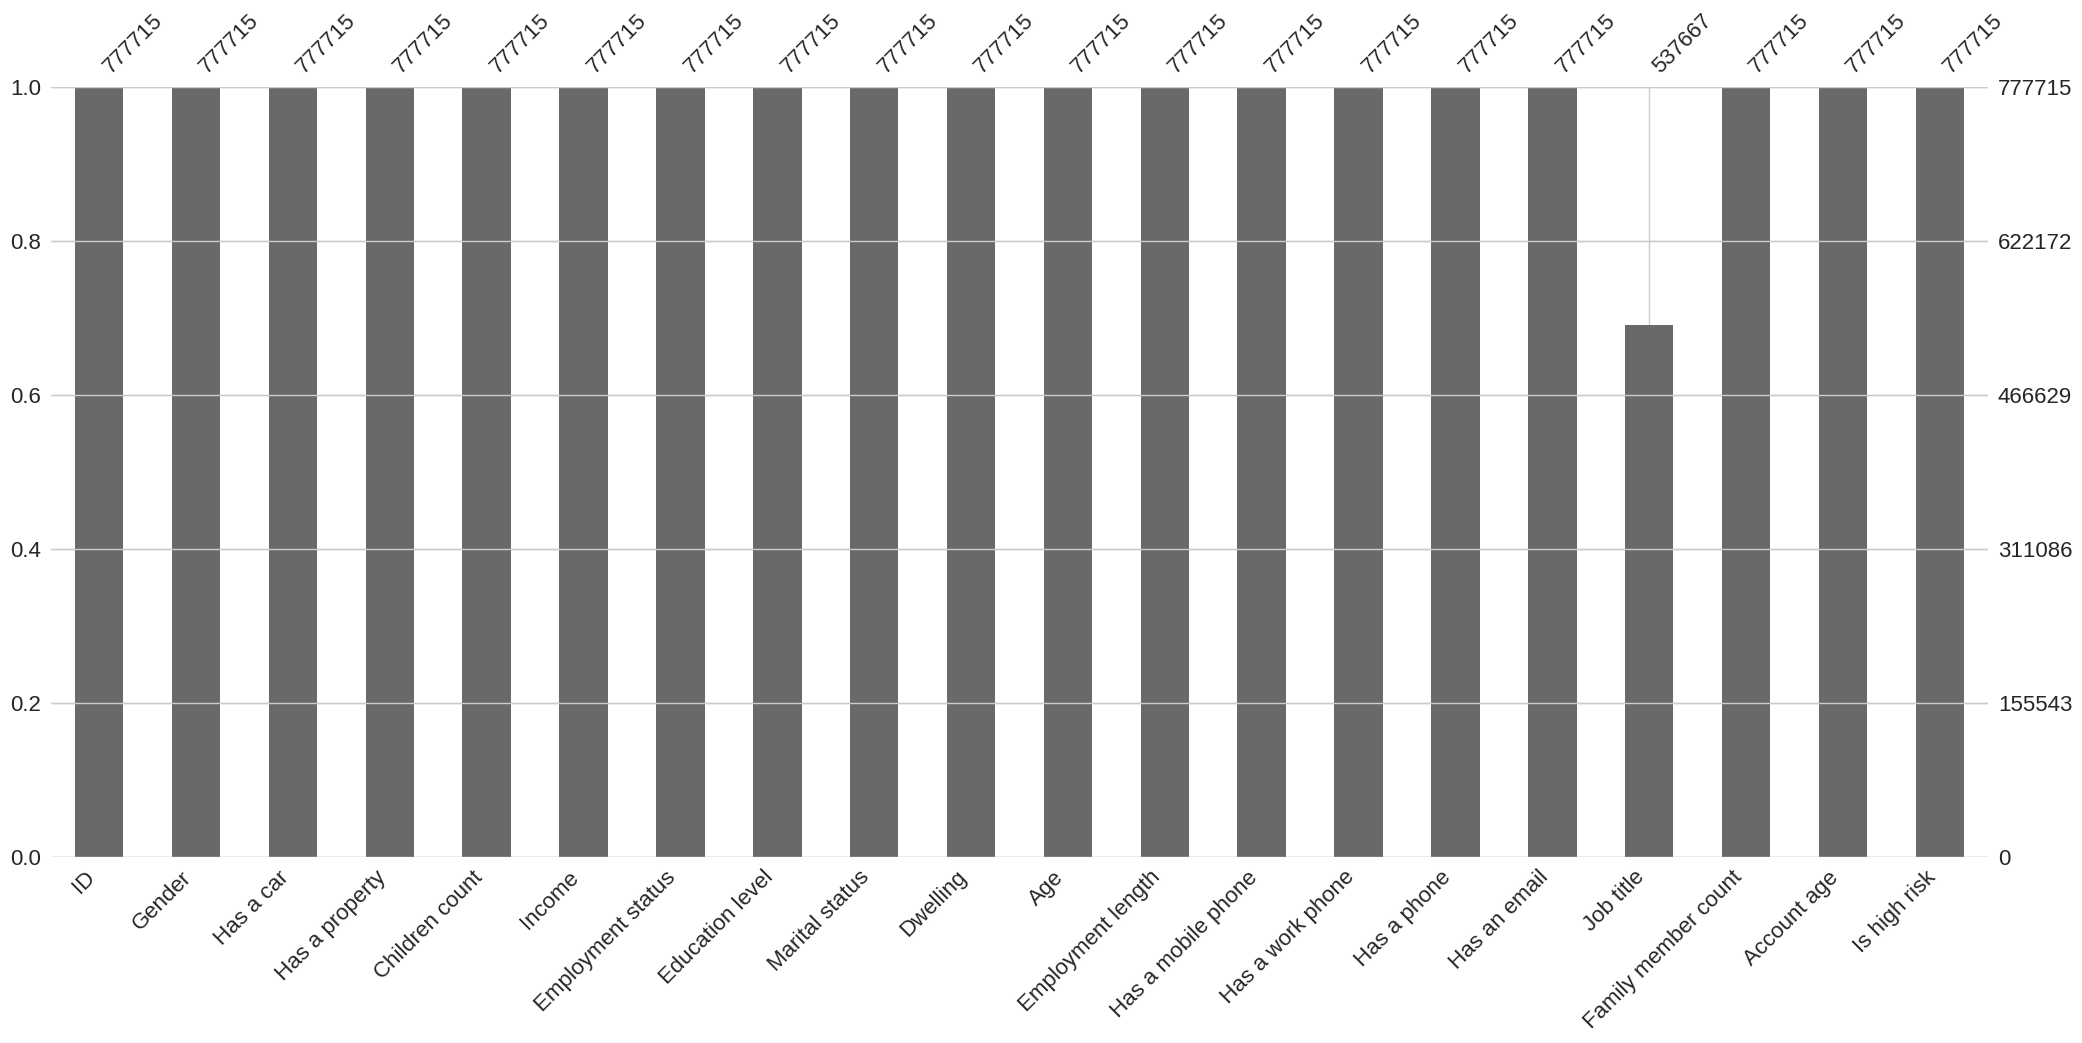

In [ ]:
import missingno as msno
msno.bar(df_application)
plt.show()

Functions For EDA

In [ ]:
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat


In [ ]:
def gen_info_feat(df,feature):
    '''function to display general information about the feature'''
    if feature == 'Age':
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    if feature == 'Employment length':
        employment_len_no_ret = df_application_copy['Employment length'][df_application_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    if feature == 'Account age' or feature == 'Income':
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
        print('Description:\n{}'.format(df[feature].describe()))
        print('*'*50)
        print('Object type:\n{}'.format(df[feature].dtype))
        print('*'*50)
        value_cnt = value_cnt_norm_cal(df,feature)
        print('Value count:\n{}'.format(value_cnt))



In [ ]:
def create_pie_plot(df,feature):
    if feature == 'Dwelling' or feature == 'Education level':

        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels=ratio_size.index)
        plt.axis('equal')

        return plt.show()
    else:
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()


In [ ]:
def create_bar_plot(df,feature):
    if feature == 'Marital status' or feature == 'Dwelling' or feature == 'Job title' or feature == 'Employment status' or feature == 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()


In [ ]:
def create_box_plot(df,feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    if feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    if feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = df_application_copy['Employment length'][df_application_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()


In [ ]:
def create_hist_plot(df,feature, the_bins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Employment length':
        employment_len_no_ret = df_application_copy['Employment length'][df_application_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()

In [ ]:
def low_high_risk_box_plot(df,feature):
    if feature == 'Age':
        print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by age')
        return plt.show()
    if feature == 'Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    if feature == 'Employment length':
        employment_no_ret = df_application_copy['Employment length'][df_application_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        employment_no_ret_df = df_application_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else:
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()

In [ ]:
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

Description:
count     777715
unique         2
top            F
freq      518851
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
         Count  Frequency (%)
Gender                       
F       518851      66.714799
M       258864      33.285201


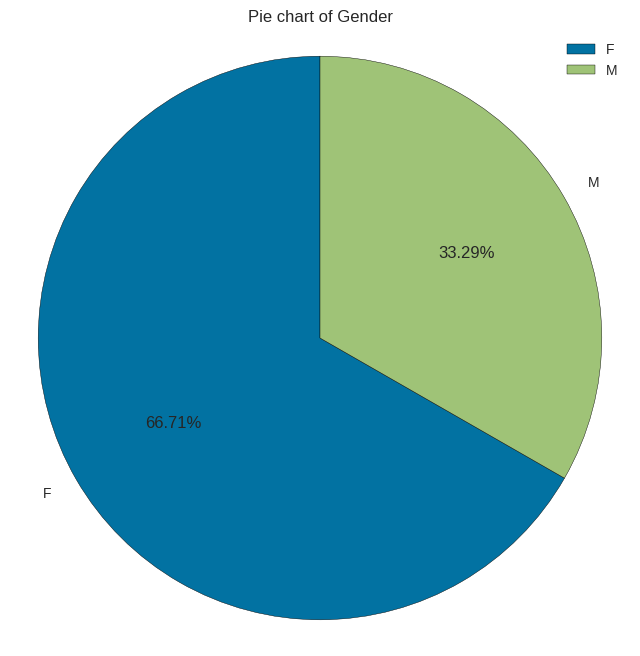

In [ ]:
gen_info_feat(df_application_copy,'Gender')
create_pie_plot(df_application_copy,'Gender')

In [ ]:
gen_info_feat(df_application_copy ,'Age')

Description:
count    777715.000000
mean         44.147672
std          11.236972
min          20.503765
25%          34.814511
50%          43.148528
75%          53.259411
max          68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64
Description:
count    777715.000000
mean     -16124.937046
std        4104.304018
min      -25152.000000
25%      -19453.000000
50%      -15760.000000
75%      -12716.000000
max       -7489.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
Age                         
-14667   1018       0.130896
-15140    928       0.119324
-15675    835       0.107366
-15519    799       0.102737
-16995    799       0.102737
...       ...            ...
-18983      1       0.000129
-10119      1       0.000129
-19526      1       0.000129
-7489       1       0.000129
-91

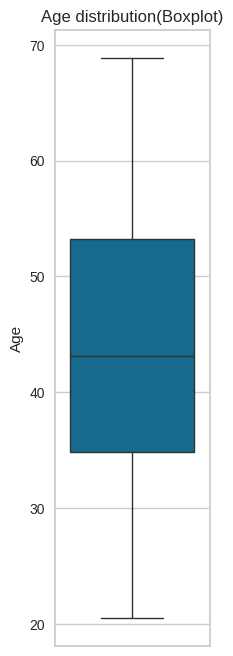

In [ ]:
create_box_plot(df_application_copy ,'Age')

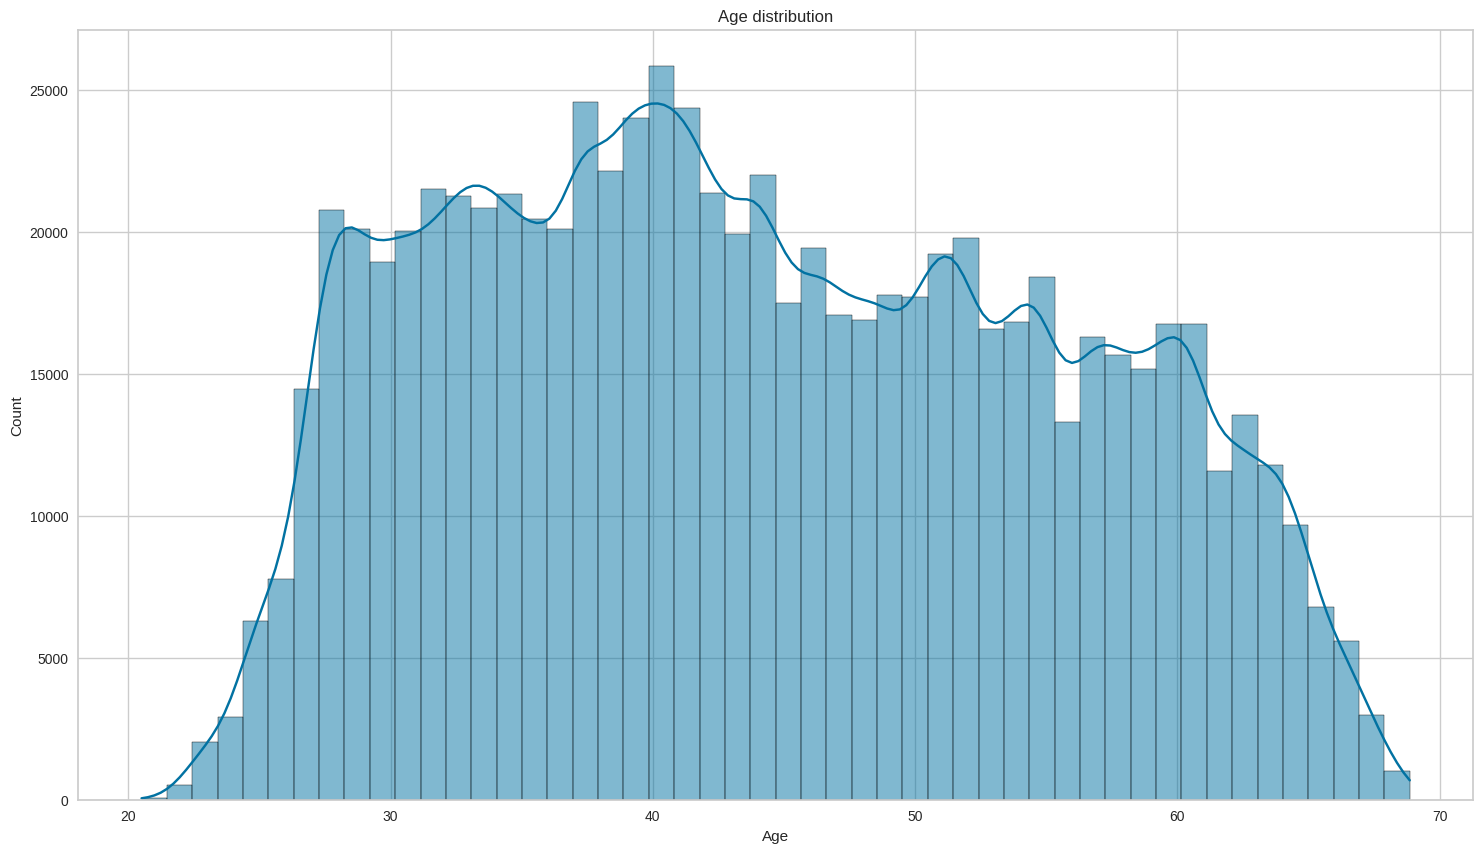

In [ ]:
create_hist_plot(df_application_copy ,'Age')

Description:
count      777715
unique          5
top       Married
freq       546619
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Marital status                             
Married               546619      70.285259
Single / not married   94335      12.129765
Civil marriage         60342       7.758883
Separated              45255       5.818970
Widow                  31164       4.007123


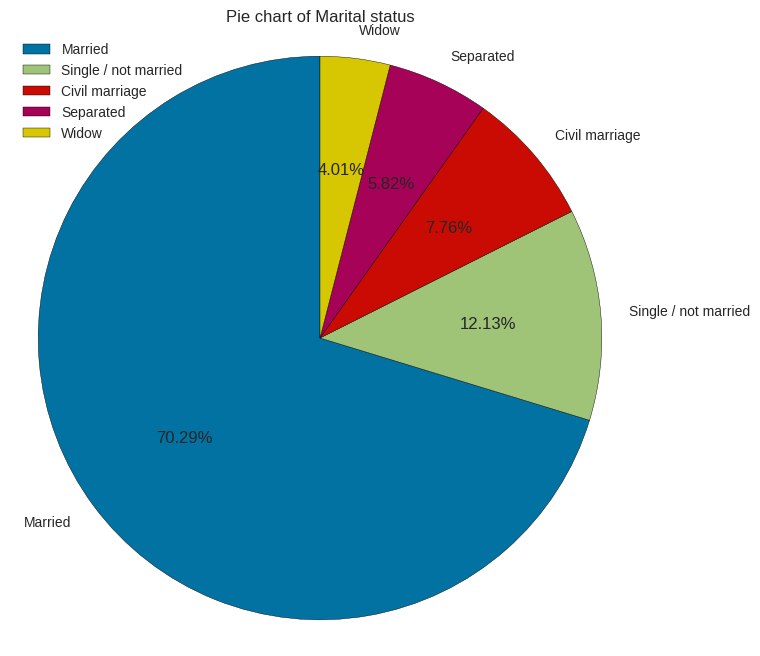

{'Married': 1953, 'Single / not married': 448, 'Separated': 171, 'Widow': 150, 'Civil marriage': 106}


<ipython-input-31-b98058080669>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')


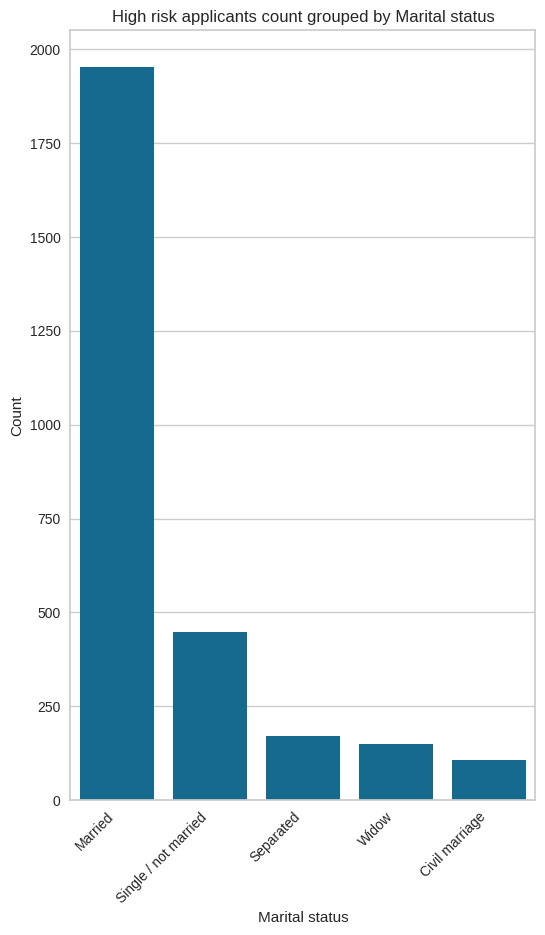

In [ ]:
gen_info_feat(df_application_copy ,'Marital status')
create_pie_plot(df_application_copy ,'Marital status')
low_high_risk_bar_plot(df_application_copy ,'Marital status')

Description:
count    777715.000000
mean          2.208837
std           0.907380
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                      Count  Frequency (%)
Family member count                       
2.0                  423723      54.483069
1.0                  141477      18.191368
3.0                  134894      17.344914
4.0                   66990       8.613695
5.0                    8999       1.157108
6.0                    1196       0.153784
7.0                     273       0.035103
15.0                    111       0.014273
9.0                      46       0.005915
20.0                      6       0.000771


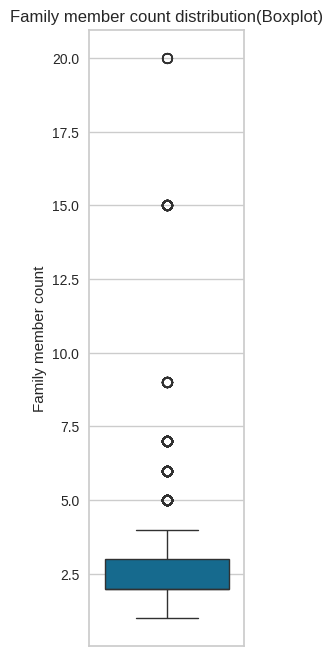

In [ ]:
gen_info_feat(df_application_copy ,'Family member count')
create_box_plot(df_application_copy ,'Family member count')

Description:
count    777715.000000
mean          0.428082
std           0.745755
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                 Count  Frequency (%)
Children count                       
0               540639      69.516340
1               155638      20.012215
2                70399       9.052031
3                 9328       1.199411
4                 1224       0.157384
5                  324       0.041661
14                 111       0.014273
7                   46       0.005915
19                   6       0.000771


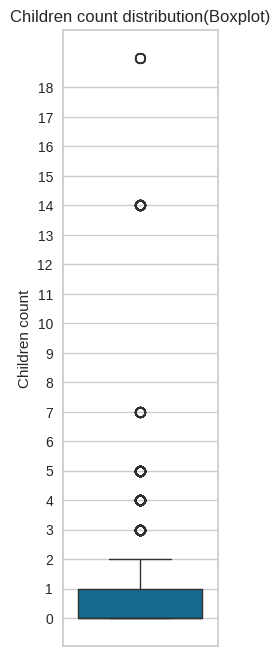

In [ ]:
gen_info_feat(df_application_copy ,'Children count')
create_box_plot(df_application_copy ,'Children count')

<ipython-input-27-80da51c41187>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')


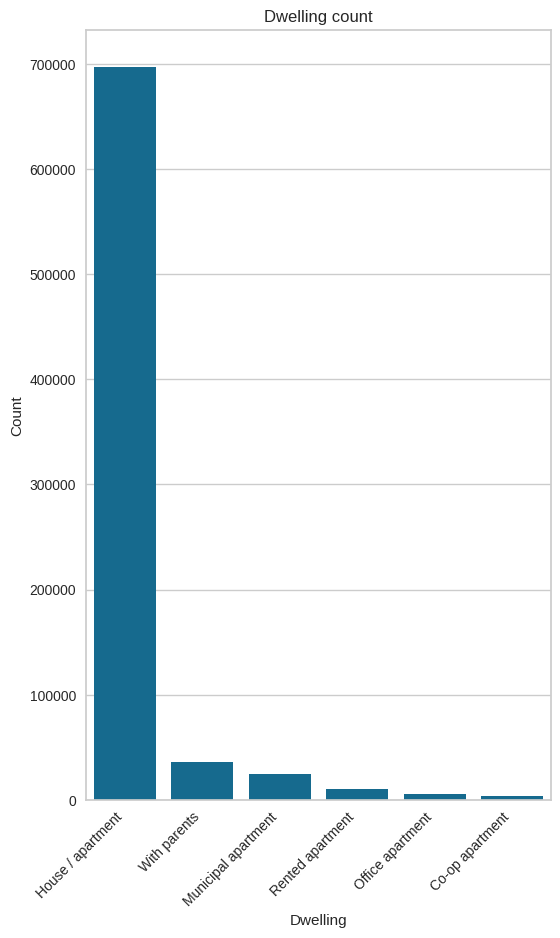

In [ ]:
create_bar_plot(df_application_copy ,'Dwelling')

Description:
count    777715.00
mean     188534.80
std      101622.45
min       27000.00
25%      121500.00
50%      162000.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:float64


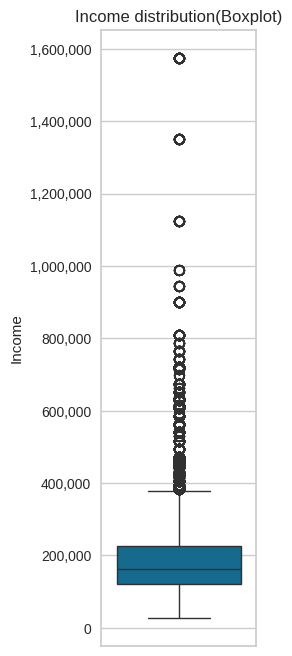

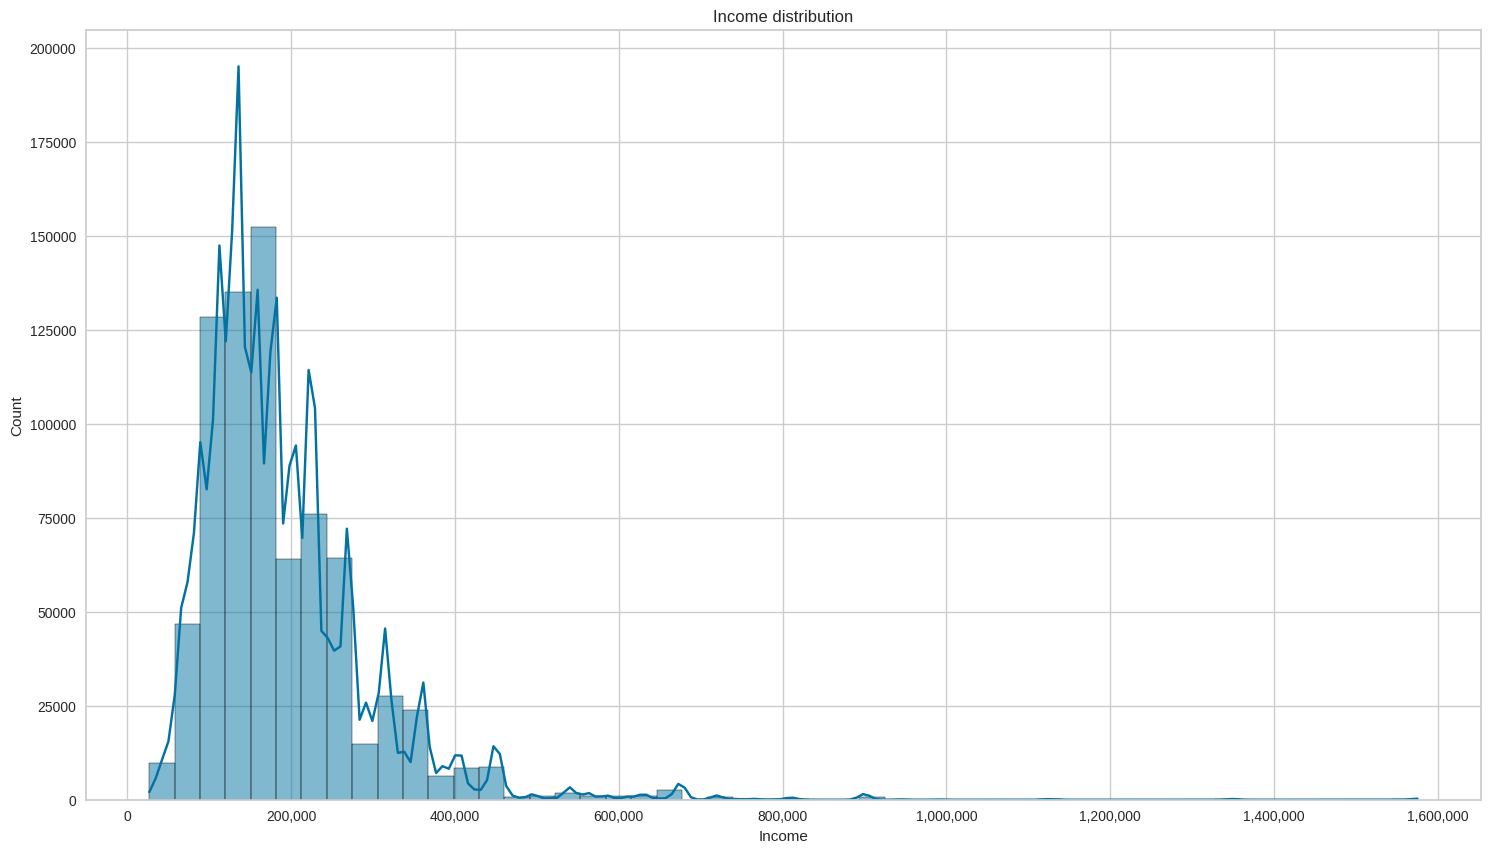

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(df_application_copy,'Income')
create_box_plot(df_application_copy ,'Income')
create_hist_plot(df_application_copy ,'Income')

In [ ]:
gen_info_feat(df_application_copy ,'Job title')

Description:
count       537667
unique          18
top       Laborers
freq        131572
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                        Count  Frequency (%)
Job title                                   
Laborers               131572          24.47
Core staff              77112          14.34
Sales staff             70362          13.09
Managers                67738          12.60
Drivers                 47678           8.87
High skill tech staff   31768           5.91
Accountants             27223           5.06
Medicine staff          26691           4.96
Cooking staff           13416           2.50
Security staff          12400           2.31
Cleaning staff          11399           2.12
Private service staff    6714           1.25
Low-skill Laborers       3623           0.67
Secretaries              3149           0.59
Waiters/barmen staff     

In [ ]:
job_title_nan_count = df_application_copy ['Job title'].isna().sum()
job_title_nan_count

240048

In [ ]:
rows_total_count = df_application_copy .shape[0]
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.87 %


<ipython-input-27-80da51c41187>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')


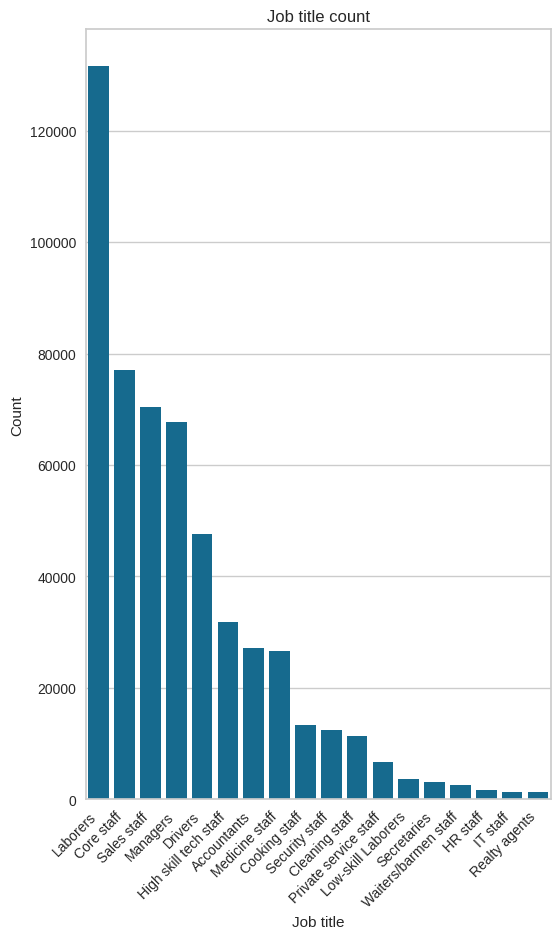

In [ ]:
create_bar_plot(df_application_copy,'Job title')

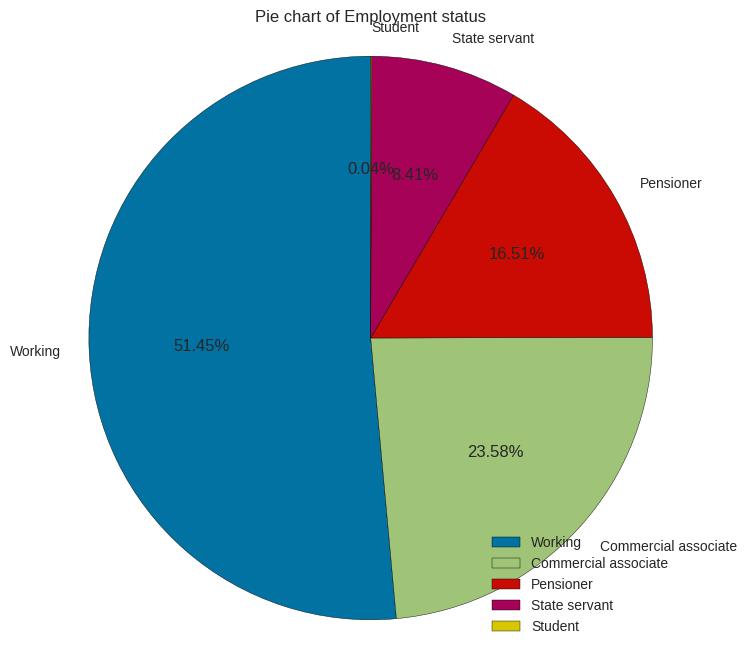

In [ ]:
create_pie_plot(df_application_copy ,'Employment status')

In [ ]:
gen_info_feat(df_application_copy ,'Education level')

Description:
count                            777715
unique                                5
top       Secondary / secondary special
freq                             524261
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                                Count  Frequency (%)
Education level                                     
Secondary / secondary special  524261          67.41
Higher education               213633          27.47
Incomplete higher               30329           3.90
Lower secondary                  8655           1.11
Academic degree                   837           0.11


Description:
count   649743.00
mean         7.62
std          6.62
min          0.05
25%          2.87
50%          5.95
75%         10.08
max         43.02
Name: Employment length, dtype: float64
**************************************************
Object type:int64
Description:
count   777715.00
mean     57775.83
std     136471.74
min     -15713.00
25%      -3292.00
50%      -1682.00
75%       -431.00
max     365243.00
Name: Employment length, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                    Count  Frequency (%)
Employment length                       
 365243            127972          16.45
-1751                1601           0.21
-1539                1545           0.20
-401                 1498           0.19
-2531                1319           0.17
...                   ...            ...
-3294                   1           0.00
-3891                   1         

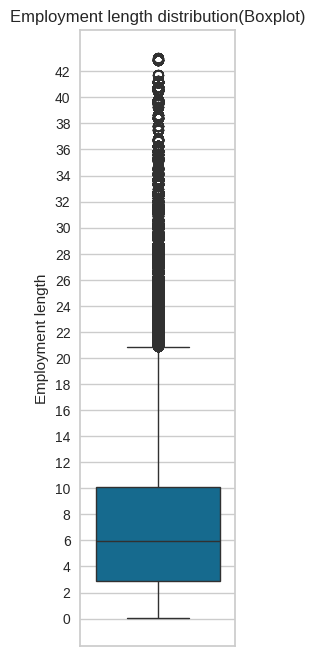

In [ ]:
gen_info_feat(df_application_copy ,'Employment length')
create_box_plot(df_application_copy ,'Employment length')

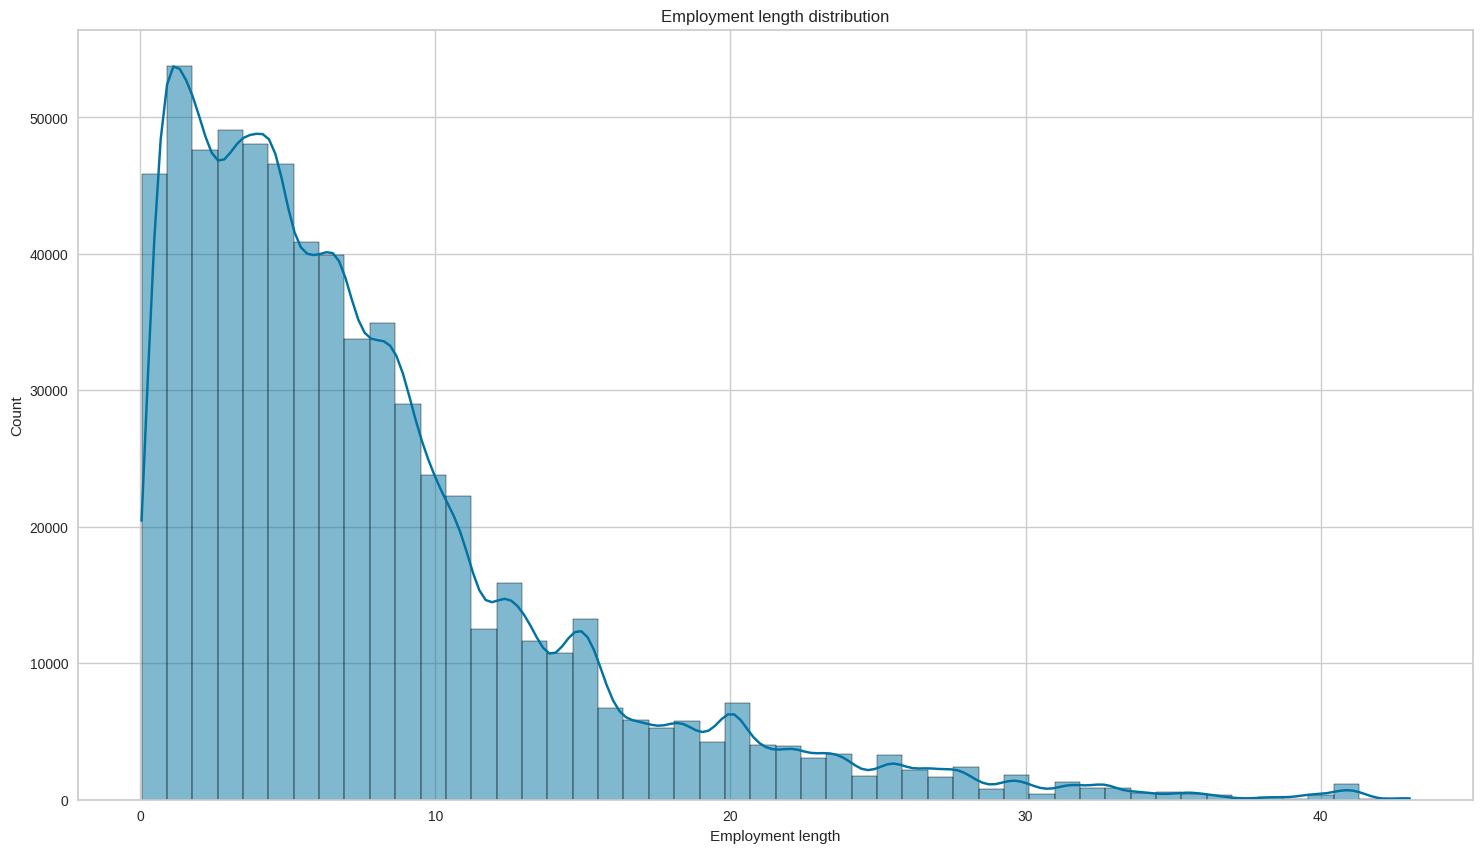

In [ ]:
create_hist_plot(df_application_copy ,'Employment length')

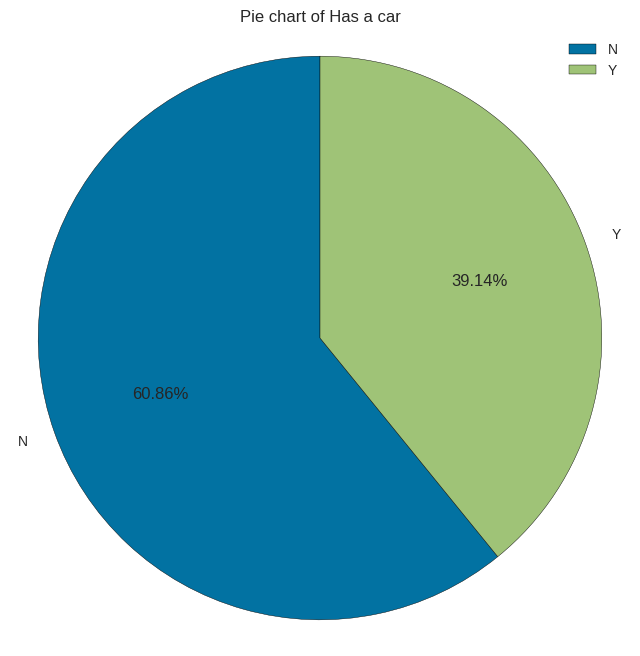

In [ ]:
create_pie_plot(df_application_copy ,'Has a car')

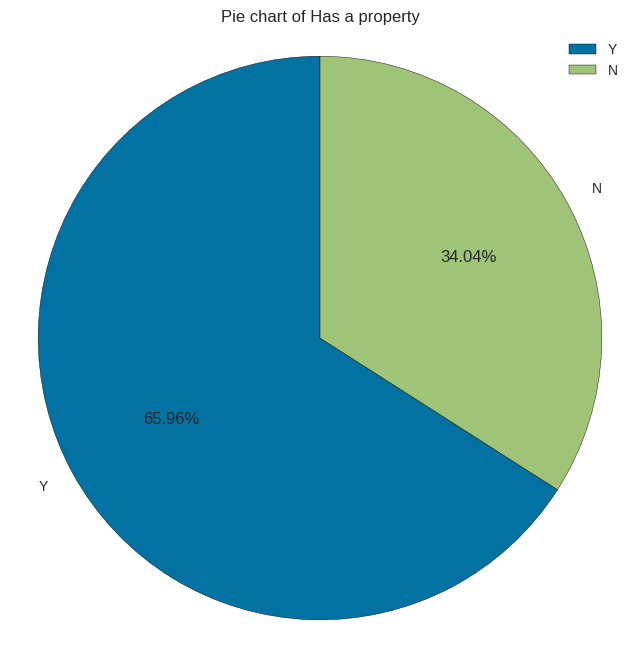

In [ ]:
create_pie_plot(df_application_copy ,'Has a property')

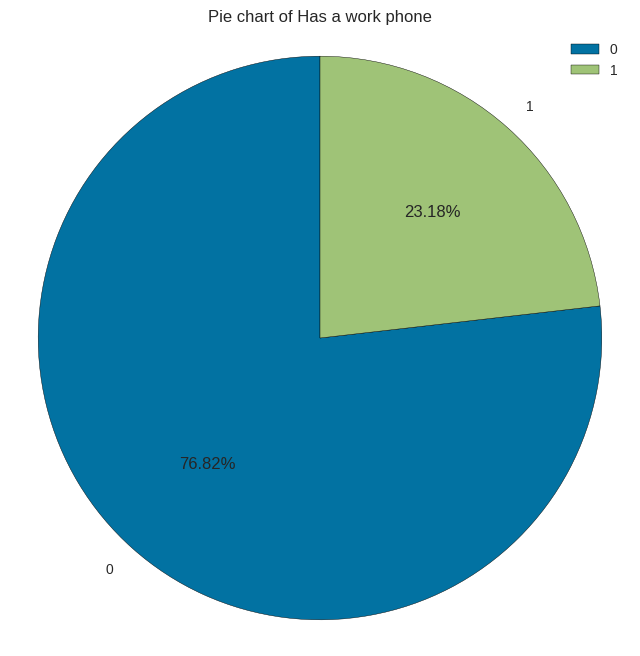

In [ ]:
create_pie_plot(df_application_copy ,'Has a work phone')

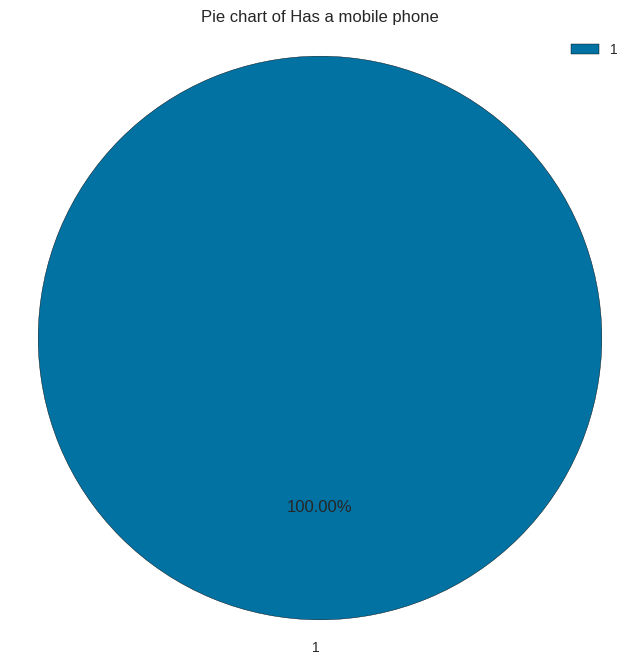

In [ ]:
create_pie_plot(df_application_copy ,'Has a mobile phone')

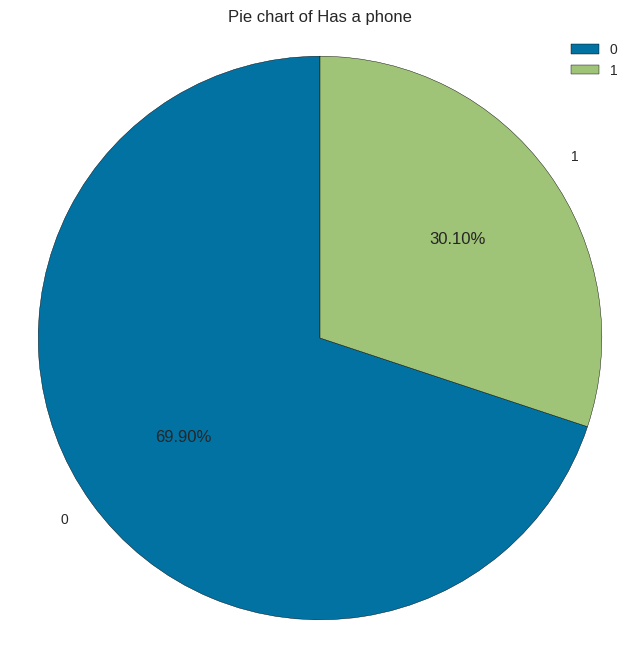

In [ ]:
create_pie_plot(df_application_copy ,'Has a phone')

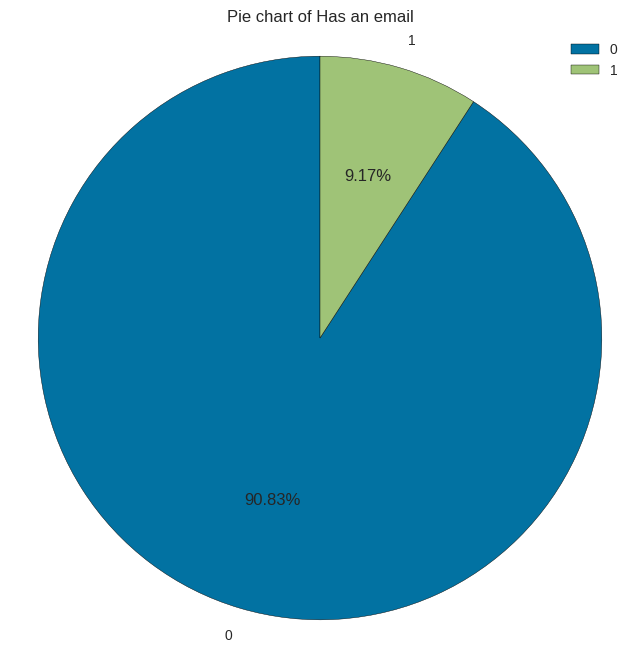

In [ ]:
create_pie_plot(df_application_copy ,'Has an email')

Description:
count   777715.00
mean        34.75
std         15.03
min          0.00
25%         23.00
50%         36.00
75%         47.00
max         60.00
Name: Account age, dtype: float64
**************************************************
Object type:int64


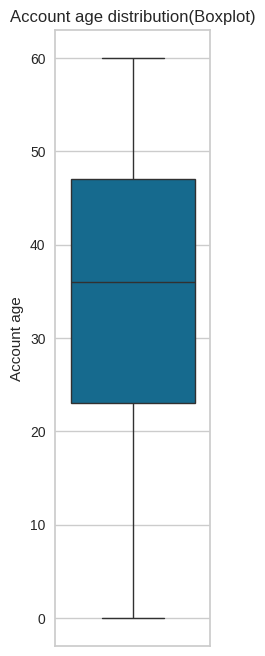

In [ ]:
gen_info_feat(df_application_copy,'Account age')
create_box_plot(df_application_copy,'Account age')

In [ ]:
gen_info_feat(df_application_copy ,'Is high risk')

Description:
count   777715.00
mean         0.00
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: Is high risk, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
               Count  Frequency (%)
Is high risk                       
0             774887          99.64
1               2828           0.36


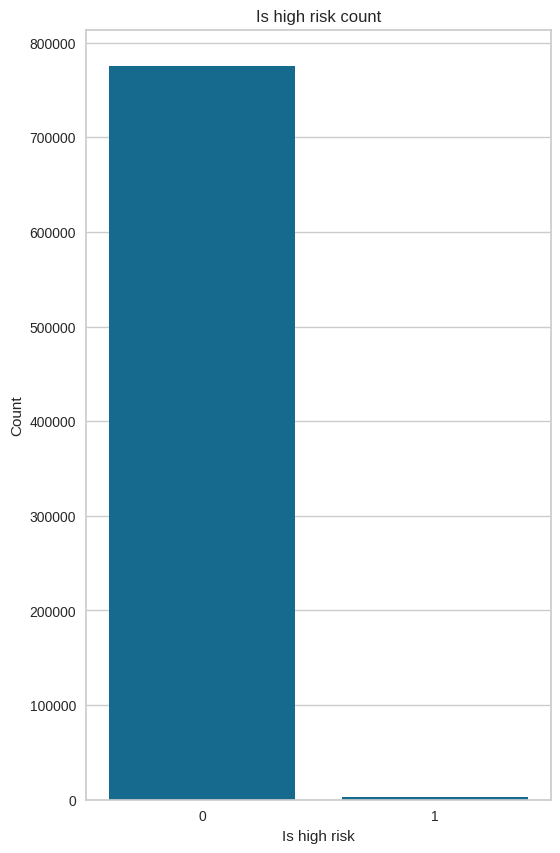

In [ ]:
create_bar_plot(df_application_copy ,'Is high risk')

In [ ]:
df_application_copy['Is high risk']=df_application_copy['Is high risk'].astype('int32')

In [ ]:
df_application_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   Gender               777715 non-null  object 
 2   Has a car            777715 non-null  object 
 3   Has a property       777715 non-null  object 
 4   Children count       777715 non-null  int64  
 5   Income               777715 non-null  float64
 6   Employment status    777715 non-null  object 
 7   Education level      777715 non-null  object 
 8   Marital status       777715 non-null  object 
 9   Dwelling             777715 non-null  object 
 10  Age                  777715 non-null  int64  
 11  Employment length    777715 non-null  int64  
 12  Has a mobile phone   777715 non-null  int64  
 13  Has a work phone     777715 non-null  int64  
 14  Has a phone          777715 non-null  int64  
 15  Has an email     

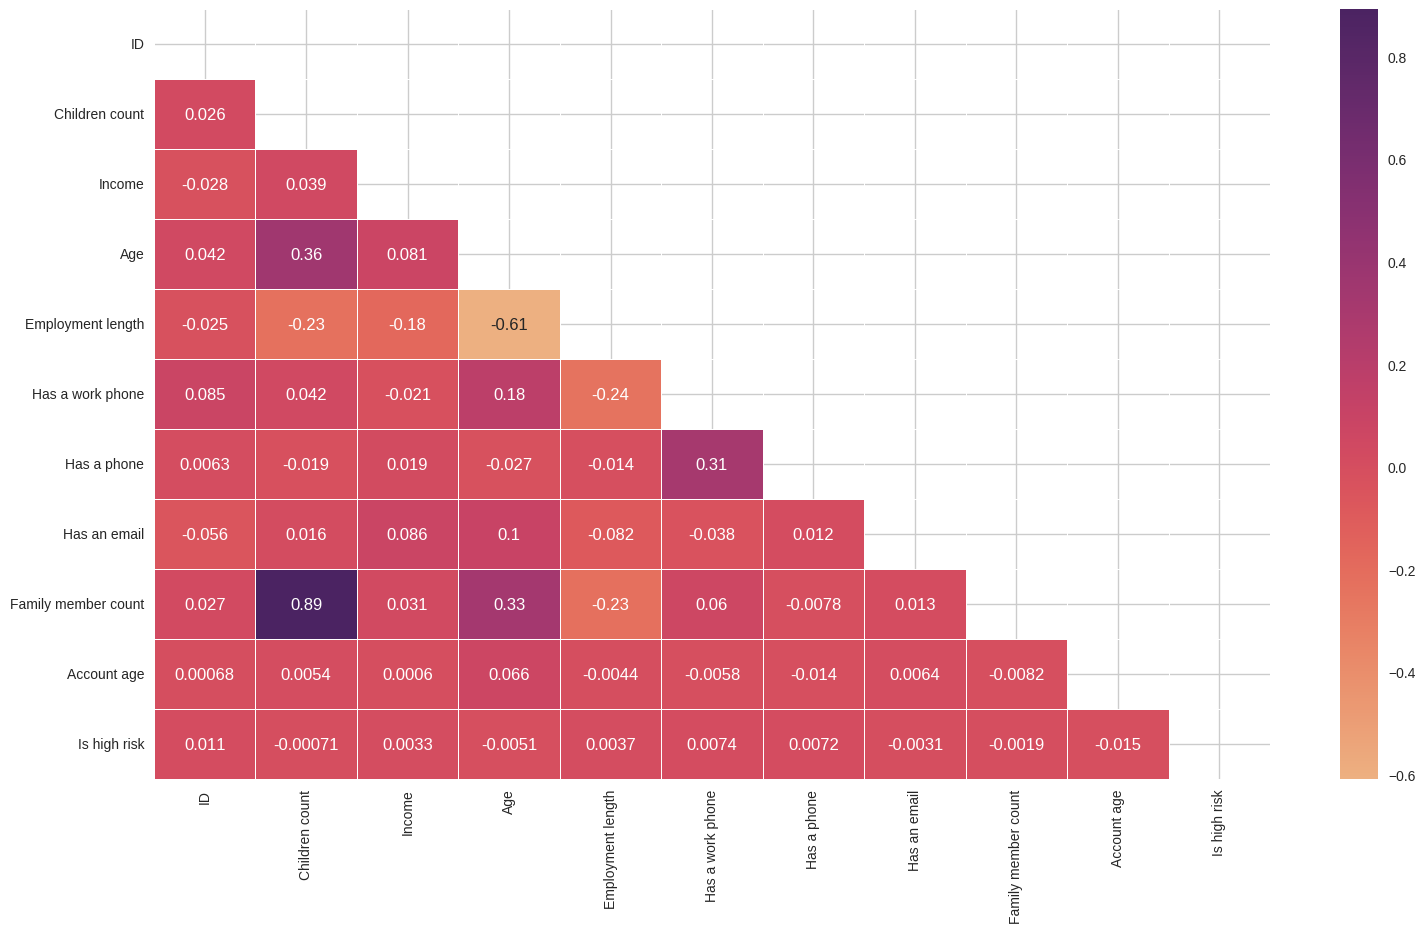

In [ ]:
numerical_df =df_application_copy .select_dtypes(include=['int64', 'int32', 'float64'])
numerical_df = numerical_df.drop(columns=['Has a mobile phone'])
# Compute the correlation matrix
cc_train_copy_corr_no_mobile = numerical_df.corr()
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        # initializing the instance of the object
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        # check if the feature in part of the dataset's features
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR only and discard the rest
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


In [ ]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            # drop the list of features
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


In [ ]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value using NumPy
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X


In [ ]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with an employment length is 365243, which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # set those rows with value 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df


In [ ]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


In [ ]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one-hot encode the features
            def one_hot_enc(df,one_hot_enc_ft):
                # instantiate the OneHotEncoder object
                one_hot_enc = OneHotEncoder()
                # fit the dataframe with the features we want to one-hot encode
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get output feature names for transformation.
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the one hot encoding array to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenate the one hot encoded features with the rest of the features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features that are not encoded
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # call the one_hot_enc function and stores the dataframe in the one_hot_enc_df variable
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe and stores it in the full_df_one_hot_enc variable
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df


In [ ]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            # instantiate the OrdinalEncoder object
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df


In [ ]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            # instantiate the MinMaxScaler object
            min_max_enc = MinMaxScaler()
            # fit and transform on a scale 0 to 1
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


In [ ]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        # check if the target is part of the dataframe
        if 'Is high risk' in df.columns:
            # change to a numeric data type using Pandas
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df


In [ ]:
from imblearn.over_sampling import SMOTE
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function instantiation to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            # fit and resample the classes and assign them to X_bal, y_bal variable
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            # concatenate the balanced classes column-wise
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df


In [ ]:
from sklearn.pipeline import Pipeline
def full_pipeline(df):
    # Create the pipeline that will call all the classes from OutlierRemoval() to Oversample() in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep


In [ ]:
df_application_copy.shape

(777715, 20)

In [ ]:
pd.options.mode.chained_assignment = None
cc_train_prep = full_pipeline(df_application_copy)

In [ ]:
cc_train_prep.shape

(1264710, 34)

In [ ]:
cc_train_prep.info()
pd.set_option('display.max_columns', None)
cc_train_prep.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264710 entries, 0 to 1264709
Data columns (total 34 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   Gender_F                                1264710 non-null  float64
 1   Gender_M                                1264710 non-null  float64
 2   Marital status_Civil marriage           1264710 non-null  float64
 3   Marital status_Married                  1264710 non-null  float64
 4   Marital status_Separated                1264710 non-null  float64
 5   Marital status_Single / not married     1264710 non-null  float64
 6   Marital status_Widow                    1264710 non-null  float64
 7   Dwelling_Co-op apartment                1264710 non-null  float64
 8   Dwelling_House / apartment              1264710 non-null  float64
 9   Dwelling_Municipal apartment            1264710 non-null  float64
 10  Dwelling_Office apartment     

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count,Is high risk
0,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00,0
1,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00,0
2,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00,0
3,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00,0
4,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00,0


In [ ]:
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')


In [ ]:
X_cc_train_prep.head()


,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count
0,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00
1,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00
2,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00
3,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00
4,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.89,1.00,0.35,0.38,2.00


In [ ]:
y_cc_train_prep.head()


,Is high risk
0,0
1,0
2,0
3,0
4,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cc_train_prep, y_cc_train_prep, test_size=0.2, random_state=42)




Random Forest Metrics:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    126480
           1       0.97      1.00      0.98    126462

    accuracy                           0.98    252942
   macro avg       0.98      0.98      0.98    252942
weighted avg       0.98      0.98      0.98    252942



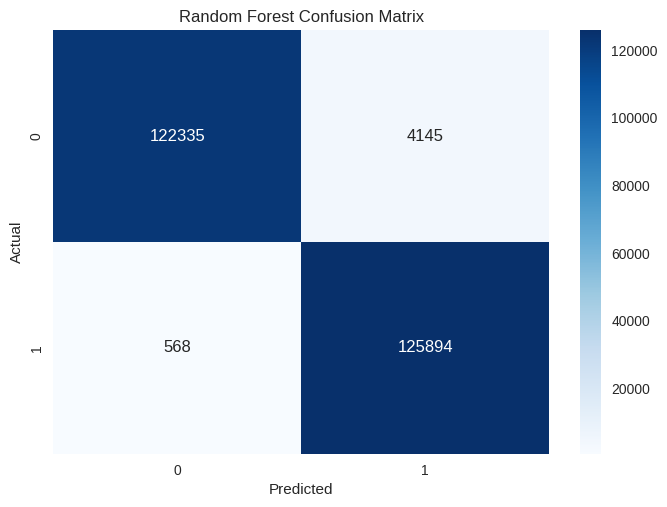

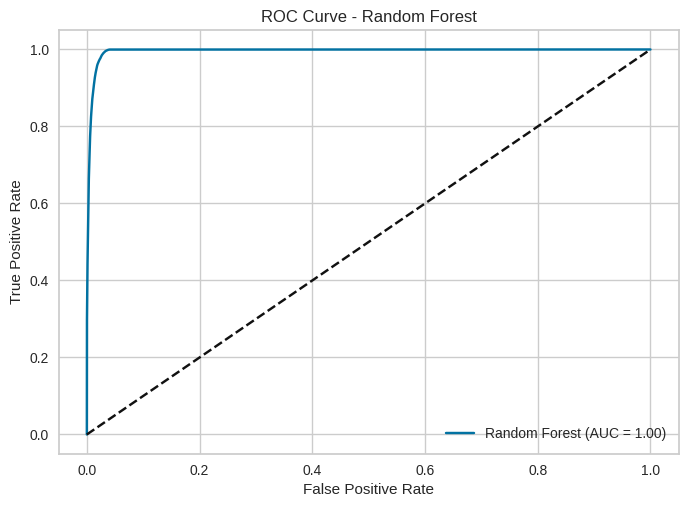

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,precision_score, recall_score, f1_score, accuracy_score)
from sklearn.preprocessing import LabelBinarizer
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Metrics:\n", classification_report(y_test, rf_preds))
def plot_confusion_matrix(y_true, y_preds, title):
    cm = confusion_matrix(y_true, y_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
plot_confusion_matrix(y_test, rf_preds, "Random Forest Confusion Matrix")
# ROC curve plotting
def plot_roc_curve(model, X_test, y_test, title):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(rf_model, X_test, y_test, "Random Forest")